# A beginner's guide to PySDDR

We start by importing the sddr module and other required libraries:

In [1]:
# /Users/dingyi/Documents/Github/VI/.venv/bin/python -m pip install .

from sddr import Sddr

import torch.nn as nn
import pandas as pd
import torch.optim as optim

# First use case: A Simple GAM Poisson Distribution

### User inputs 

First the user defines the data to be used:

In [2]:
# define data location
data_path = '../data/simple_gam/X.csv'
target_path = '../data/simple_gam/Y.csv'
# read data into pandas dataframe
data = pd.read_csv(data_path,delimiter=';')
target = pd.read_csv(target_path)
# split the data into train and test to use later for predictions
train_data = data.iloc[:800]
train_target = target.iloc[:800]
test_data = data.iloc[800:]

In [3]:
# define distribution and the formula for the distibutional parameter
distribution  = 'Poisson'
formulas = {'rate': '~1+spline(x1, bs="bs",df=9)+spline(x2, bs="bs",df=9)+d1(x1)+d2(x2)'}

# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 1000,
    'epochs': 200,
    'degrees_of_freedom': {'rate': 6},
    'optimizer' : optim.RMSprop,
    'val_split': 0.1,
    'dropout_rate': 0.1
    }

# define output directory
output_dir = './outputs'

Alternatively these parameters can be defined in a config file (for example see config.yaml)

### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [4]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

Using device:  cpu


Alternatively, the initialization can be done with a config file:

In [24]:
'''
import yaml

# get config
def get_config(config):
    with open(config, 'r') as stream:
        return yaml.safe_load(stream)

#load config file
config = get_config('config.yaml') 
# initialize sddr instance
sddr = Sddr(config=config)
'''

"\nimport yaml\n\n# get config\ndef get_config(config):\n    with open(config, 'r') as stream:\n        return yaml.safe_load(stream)\n\n#load config file\nconfig = get_config('config.yaml') \n# initialize sddr instance\nsddr = Sddr(config=config)\n"

Since this will load all data from a file without splitting into train and test as we have done above, we have commented this part out for now. Also note that the config.yaml option currently only works if the deep networks are defined as in the ```config.yaml``` (directly with modules from torch.nn given as strings) and does not accept local scripts or torch models

### Training

The sddr network is trained with the data defined above and the loss curve is plotted. Note that in this example we only have tabular data so unstructured_data is not given.

Beginning training ...
Train Epoch: 0 	 Training Loss: 148.246872
Train Epoch: 0 	 Validation Loss: 161.264145


/Users/dingyi/Documents/Github/VI/.venv/lib/python3.9/site-packages/sddr/sddrnetwork.py:107: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  Q, R = torch.qr(X_sliced_with_orthogonalization_pattern)


Train Epoch: 20 	 Training Loss: 85.954048
Train Epoch: 20 	 Validation Loss: 99.895714
Train Epoch: 40 	 Training Loss: 55.584091
Train Epoch: 40 	 Validation Loss: 60.639660
Train Epoch: 60 	 Training Loss: 40.158279
Train Epoch: 60 	 Validation Loss: 45.350349
Train Epoch: 80 	 Training Loss: 28.391594
Train Epoch: 80 	 Validation Loss: 27.281887
Train Epoch: 100 	 Training Loss: 24.223560
Train Epoch: 100 	 Validation Loss: 26.621355
Train Epoch: 120 	 Training Loss: 16.888433
Train Epoch: 120 	 Validation Loss: 15.852345
Train Epoch: 140 	 Training Loss: 19.284359
Train Epoch: 140 	 Validation Loss: 14.087025
Train Epoch: 160 	 Training Loss: 18.912233
Train Epoch: 160 	 Validation Loss: 16.851336
Train Epoch: 180 	 Training Loss: 19.104013
Train Epoch: 180 	 Validation Loss: 12.554774


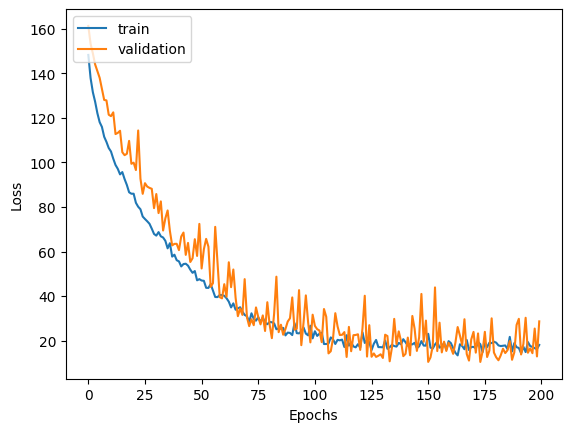

In [5]:
sddr.train(structured_data=train_data,
           target=train_target,
           plot=True)

### Visualizing the partial effects

The partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

In the case below the model is a generalized additive model with two splines (one has a quadratic effect, one has only a linear effect), while target is assumed to come from a Poisson distribution. The quadratic and linear effects are confirmed when plotting the partial effects below.

#### Dropout for Structured Part (?)

Because in hyperparameter setting, the sddr.p, "dropout_rate", is set to 0.1, the eval() from class Sddr(object) will execute the "else" part

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

##### how they quantify the uncertainty for a specific parameter of the distribution
param = 'rate'
data = sddr.dataset[:]["datadict"]
# print(data)
get_feature = sddr.dataset.get_feature

# get the weights of the linear layer of the structured part - do this computation on cpu
structured_head_params = sddr.net.single_parameter_sddr_list[param].structured_head.weight.detach().cpu()
# print(structured_head_params)
print(structured_head_params.size())

# and the structured data after the smoothing
smoothed_structured = data[param]["structured"].cpu()
# print(smoothed_structured)
print(smoothed_structured.size())

# get a list of the slice that each spline has in the design matrix
list_of_spline_slices = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_slices']
print(list_of_spline_slices)

# get a list of the names of spline terms
list_of_term_names = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_term_names']
print(list_of_term_names)

 # get a list of feature names sent as input to each spline
list_of_spline_input_features = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_input_features']
print(list_of_spline_input_features)

partial_effects = []
can_plot = []
xlabels = []
ylabels = []

# for each spline
for spline_slice, spline_input_features, term_name in zip(list_of_spline_slices, list_of_spline_input_features, list_of_term_names):
    print("spline_slice: ", spline_slice)
    print("spline_input_features:", spline_input_features)
    print("term_name", term_name)
    
    # if only one feature was sent as input to spline
    if len(spline_input_features) == 1:
        # get that feature
        feature = get_feature(spline_input_features[0])
        # and keep track so that the partial effect of this spline can be plotted later on
        can_plot.append(True)
        ylabels.append(term_name)
        xlabels.append(spline_input_features[0])
    else:
        feature = []
        for feature_name in spline_input_features:
            feature.append(get_feature(feature_name))
        # the partial effect of this spline cannot be plotted later on - too complicated for now as not 2d
        can_plot.append(False)
        
    # use dropout to calculate uncertainty
    if sddr.p == 0:
        structured_pred = torch.matmul(smoothed_structured[:,spline_slice], structured_head_params[0, spline_slice])
        partial_effects.append((feature, structured_pred))
    else:
        structured_pred_dropout = []
        for dropout_iteration in range(1000):
            mask = torch.bernoulli(torch.full([1,structured_head_params.shape[1]], 1-sddr.p).float()).int()
            structured_head_params_dropout = mask * structured_head_params
            print(structured_head_params_dropout)
            structured_pred = torch.matmul(smoothed_structured[:,spline_slice], structured_head_params_dropout[0, spline_slice])*(1/(1-sddr.p))
            structured_pred_dropout.append(structured_pred.numpy())

        # mean of the dropouted result
        structured_pred = np.mean(np.array(structured_pred_dropout),axis=0)
        # calculate 95% quantile and 50% quantile
        ci950 = np.quantile(np.array(structured_pred_dropout), 0.025, axis=0)
        ci951 = np.quantile(np.array(structured_pred_dropout), 0.975, axis=0)
        ci250 = np.quantile(np.array(structured_pred_dropout), 0.25, axis=0)
        ci251 = np.quantile(np.array(structured_pred_dropout), 0.75, axis=0)
                            
        partial_effects.append((feature, structured_pred, ci950, ci951, ci250, ci251))
    

torch.Size([1, 19])
torch.Size([800, 19])
[slice(1, 10, None), slice(10, 19, None)]
['spline(x1, bs="bs", df=9)', 'spline(x2, bs="bs", df=9)']
[['x1'], ['x2']]
spline_slice:  slice(1, 10, None)
spline_input_features: ['x1']
term_name spline(x1, bs="bs", df=9)
tensor([[ 2.2234,  1.4439,  0.8569, -0.3943, -1.6941, -2.0899, -1.6585, -0.4596,
          0.7245,  1.3719,  1.4042,  1.1921,  0.8027,  0.1065, -0.5879, -1.1946,
         -1.6952, -1.9406, -2.0830]])
tensor([[ 2.2234,  1.4439,  0.8569, -0.3943, -1.6941, -2.0899, -1.6585, -0.4596,
          0.7245,  1.3719,  1.4042,  1.1921,  0.8027,  0.1065, -0.5879, -1.1946,
         -1.6952, -1.9406, -2.0830]])
tensor([[ 2.2234,  1.4439,  0.8569, -0.3943, -0.0000, -2.0899, -1.6585, -0.4596,
          0.7245,  1.3719,  1.4042,  1.1921,  0.8027,  0.1065, -0.5879, -1.1946,
         -1.6952, -1.9406, -2.0830]])
tensor([[ 2.2234,  1.4439,  0.8569, -0.3943, -1.6941, -2.0899, -0.0000, -0.4596,
          0.0000,  1.3719,  1.4042,  1.1921,  0.8027,  0.10

That's how they get the figure from their tutorial, by using dropout for UQ in structured part

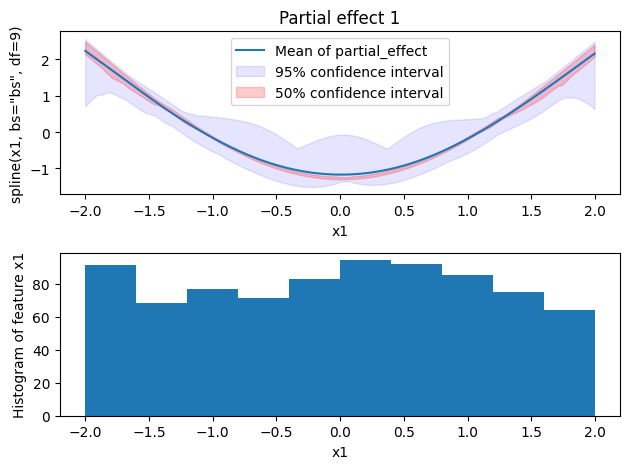

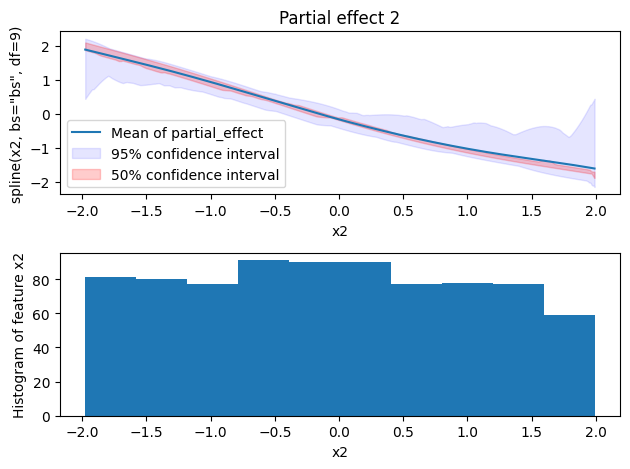

In [27]:
num_plots =  sum(can_plot)
bins = 10 # default
if num_plots == 0:
    print('Nothing to plot. No (non-)linear partial effects specified for this parameter. (Deep partial effects are not plotted.)')
elif num_plots != len(partial_effects):
    print('Cannot plot ', len(partial_effects) - num_plots, ' splines because they have more that one input')

for i in range(len(partial_effects)):
    if can_plot[i]:
        
        if sddr.p == 0:
            feature, partial_effect = partial_effects[i]
            partial_effect = [x for _,x in sorted(zip(feature, partial_effect))]
            plt.subplot(2,1,1)
            plt.scatter(np.sort(feature), partial_effect)
            plt.title('Partial effect %s' % (i+1))
            plt.ylabel(ylabels[i])
            plt.xlabel(xlabels[i])
            plt.subplot(2,1,2)
            plt.hist(feature,bins=bins)
            plt.ylabel('Histogram of feature {}'.format(xlabels[i]))
            plt.xlabel(xlabels[i])
            plt.tight_layout()
            plt.show()
        else:
            feature, partial_effect, ci950, ci951, ci250, ci251 = partial_effects[i]
            re = np.array([[x,y,m,n,o] for _,x,y,m,n,o in sorted(zip(feature, partial_effect, ci950, ci951, ci250, ci251))])
            partial_effect, ci950, ci951, ci250, ci251 = re[:,0],re[:,1],re[:,2],re[:,3],re[:,4]
            plt.subplot(2,1,1)
            plt.plot(np.sort(feature), partial_effect,label='Mean of partial_effect')
            plt.fill_between(np.sort(feature), ci950, ci951, color='b', alpha=.1, label='95% confidence interval')
            plt.fill_between(np.sort(feature), ci250, ci251, color='r', alpha=.2,label='50% confidence interval')
            plt.legend()
            plt.title('Partial effect %s' % (i+1))
            plt.ylabel(ylabels[i])
            plt.xlabel(xlabels[i])
            plt.subplot(2,1,2)
            plt.hist(feature,bins=bins)
            plt.ylabel('Histogram of feature {}'.format(xlabels[i]))
            plt.xlabel(xlabels[i])
            plt.tight_layout()
            plt.show()
#             plt.savefig(os.path.join(self.config['output_dir'], 'partial_effects.png'))

To quantify the uncertainty of linear and non-linear effects modeled via splines in a regression, you can use bootstrapping or Bayesian methods in both Python and R.

#### Simple bootstrapping in structured part


Using device:  cpu
Beginning training ...
Train Epoch: 0 	 Training Loss: 191.393677
Train Epoch: 0 	 Validation Loss: 217.149887
Train Epoch: 20 	 Training Loss: 110.713440
Train Epoch: 20 	 Validation Loss: 133.826050
Train Epoch: 40 	 Training Loss: 75.489136
Train Epoch: 40 	 Validation Loss: 94.090836
Train Epoch: 60 	 Training Loss: 52.667770
Train Epoch: 60 	 Validation Loss: 72.867165
Train Epoch: 80 	 Training Loss: 38.804100
Train Epoch: 80 	 Validation Loss: 38.708557
Train Epoch: 100 	 Training Loss: 31.634068
Train Epoch: 100 	 Validation Loss: 34.351128
Train Epoch: 120 	 Training Loss: 25.052235
Train Epoch: 120 	 Validation Loss: 23.478666
Train Epoch: 140 	 Training Loss: 19.509912
Train Epoch: 140 	 Validation Loss: 23.052372
Train Epoch: 160 	 Training Loss: 22.712729
Train Epoch: 160 	 Validation Loss: 20.517826
Train Epoch: 180 	 Training Loss: 22.109095
Train Epoch: 180 	 Validation Loss: 12.733829


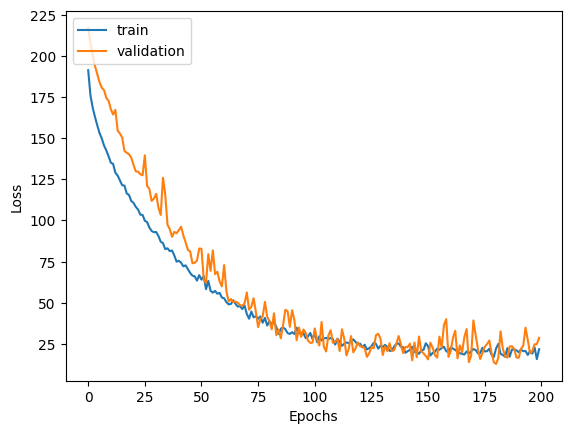

Beginning training ...
Train Epoch: 0 	 Training Loss: 138.615082
Train Epoch: 0 	 Validation Loss: 170.598450
Train Epoch: 20 	 Training Loss: 77.698746
Train Epoch: 20 	 Validation Loss: 100.929062
Train Epoch: 40 	 Training Loss: 52.091591
Train Epoch: 40 	 Validation Loss: 67.871384
Train Epoch: 60 	 Training Loss: 35.017422
Train Epoch: 60 	 Validation Loss: 41.626705
Train Epoch: 80 	 Training Loss: 26.258066
Train Epoch: 80 	 Validation Loss: 28.186924
Train Epoch: 100 	 Training Loss: 21.785170
Train Epoch: 100 	 Validation Loss: 24.747169
Train Epoch: 120 	 Training Loss: 16.896065
Train Epoch: 120 	 Validation Loss: 33.022785
Train Epoch: 140 	 Training Loss: 17.974873
Train Epoch: 140 	 Validation Loss: 29.522833
Train Epoch: 160 	 Training Loss: 16.134933
Train Epoch: 160 	 Validation Loss: 16.121410
Train Epoch: 180 	 Training Loss: 14.753372
Train Epoch: 180 	 Validation Loss: 19.883553


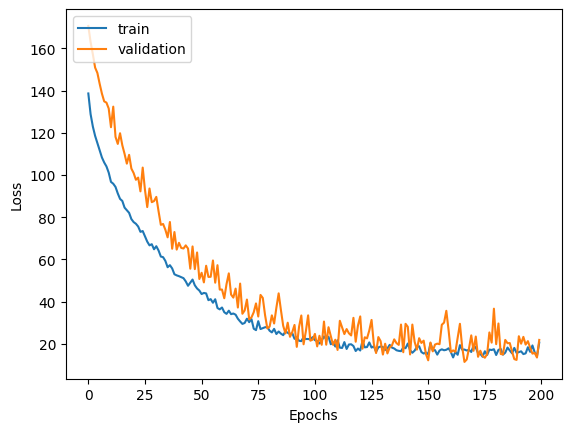

Beginning training ...
Train Epoch: 0 	 Training Loss: 145.494354
Train Epoch: 0 	 Validation Loss: 138.831451
Train Epoch: 20 	 Training Loss: 79.785904
Train Epoch: 20 	 Validation Loss: 82.887482
Train Epoch: 40 	 Training Loss: 50.451725
Train Epoch: 40 	 Validation Loss: 56.471687
Train Epoch: 60 	 Training Loss: 34.186062
Train Epoch: 60 	 Validation Loss: 29.670307
Train Epoch: 80 	 Training Loss: 25.895809
Train Epoch: 80 	 Validation Loss: 24.458986
Train Epoch: 100 	 Training Loss: 17.826180
Train Epoch: 100 	 Validation Loss: 11.826317
Train Epoch: 120 	 Training Loss: 19.125816
Train Epoch: 120 	 Validation Loss: 24.706741
Train Epoch: 140 	 Training Loss: 16.519953
Train Epoch: 140 	 Validation Loss: 16.381069
Train Epoch: 160 	 Training Loss: 16.279469
Train Epoch: 160 	 Validation Loss: 12.890903
Train Epoch: 180 	 Training Loss: 18.188267
Train Epoch: 180 	 Validation Loss: 22.439125


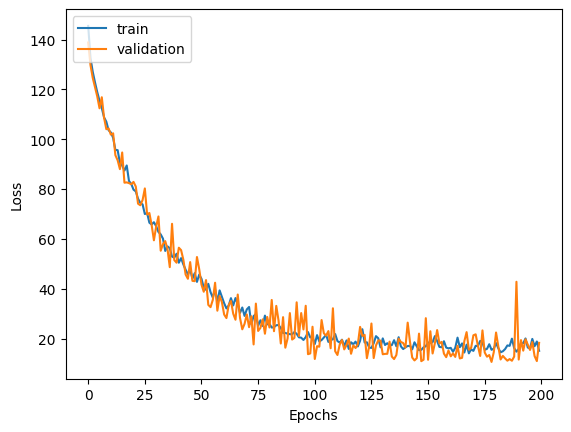

Beginning training ...
Train Epoch: 0 	 Training Loss: 154.919296
Train Epoch: 0 	 Validation Loss: 159.409302
Train Epoch: 20 	 Training Loss: 89.267082
Train Epoch: 20 	 Validation Loss: 95.526772
Train Epoch: 40 	 Training Loss: 60.370232
Train Epoch: 40 	 Validation Loss: 65.709106
Train Epoch: 60 	 Training Loss: 41.868847
Train Epoch: 60 	 Validation Loss: 50.198906
Train Epoch: 80 	 Training Loss: 34.370243
Train Epoch: 80 	 Validation Loss: 32.187046
Train Epoch: 100 	 Training Loss: 23.725840
Train Epoch: 100 	 Validation Loss: 26.422047
Train Epoch: 120 	 Training Loss: 19.926872
Train Epoch: 120 	 Validation Loss: 16.194498
Train Epoch: 140 	 Training Loss: 18.640038
Train Epoch: 140 	 Validation Loss: 11.991964
Train Epoch: 160 	 Training Loss: 20.588919
Train Epoch: 160 	 Validation Loss: 14.948741
Train Epoch: 180 	 Training Loss: 18.378521
Train Epoch: 180 	 Validation Loss: 27.604176


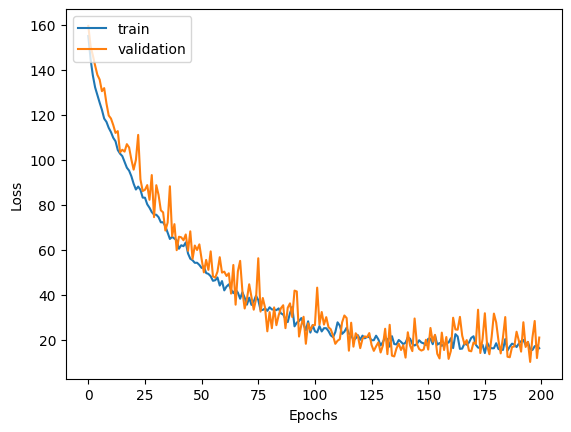

Beginning training ...
Train Epoch: 0 	 Training Loss: 130.158646
Train Epoch: 0 	 Validation Loss: 193.816269
Train Epoch: 20 	 Training Loss: 73.242996
Train Epoch: 20 	 Validation Loss: 130.392120
Train Epoch: 40 	 Training Loss: 52.331863
Train Epoch: 40 	 Validation Loss: 83.158989
Train Epoch: 60 	 Training Loss: 35.136185
Train Epoch: 60 	 Validation Loss: 60.678684
Train Epoch: 80 	 Training Loss: 25.095940
Train Epoch: 80 	 Validation Loss: 40.424862
Train Epoch: 100 	 Training Loss: 20.089493
Train Epoch: 100 	 Validation Loss: 24.020187
Train Epoch: 120 	 Training Loss: 20.137436
Train Epoch: 120 	 Validation Loss: 22.027996
Train Epoch: 140 	 Training Loss: 14.488208
Train Epoch: 140 	 Validation Loss: 31.704922
Train Epoch: 160 	 Training Loss: 17.516230
Train Epoch: 160 	 Validation Loss: 15.042919
Train Epoch: 180 	 Training Loss: 14.787258
Train Epoch: 180 	 Validation Loss: 22.847801


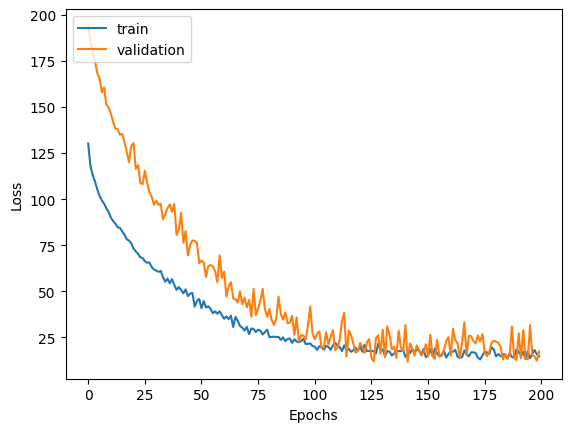

Beginning training ...
Train Epoch: 0 	 Training Loss: 135.604599
Train Epoch: 0 	 Validation Loss: 177.894241
Train Epoch: 20 	 Training Loss: 68.837379
Train Epoch: 20 	 Validation Loss: 101.363129
Train Epoch: 40 	 Training Loss: 43.716770
Train Epoch: 40 	 Validation Loss: 60.206997
Train Epoch: 60 	 Training Loss: 31.180515
Train Epoch: 60 	 Validation Loss: 42.889797
Train Epoch: 80 	 Training Loss: 23.226997
Train Epoch: 80 	 Validation Loss: 38.187771
Train Epoch: 100 	 Training Loss: 21.051697
Train Epoch: 100 	 Validation Loss: 22.963486
Train Epoch: 120 	 Training Loss: 15.617256
Train Epoch: 120 	 Validation Loss: 30.872538
Train Epoch: 140 	 Training Loss: 17.744520
Train Epoch: 140 	 Validation Loss: 18.518755
Train Epoch: 160 	 Training Loss: 17.234488
Train Epoch: 160 	 Validation Loss: 21.534250
Train Epoch: 180 	 Training Loss: 17.379337
Train Epoch: 180 	 Validation Loss: 20.452648


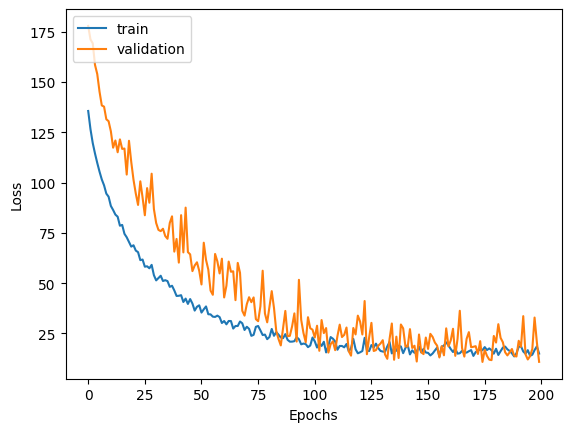

Beginning training ...
Train Epoch: 0 	 Training Loss: 154.891357
Train Epoch: 0 	 Validation Loss: 105.056091
Train Epoch: 20 	 Training Loss: 87.846458
Train Epoch: 20 	 Validation Loss: 65.302887
Train Epoch: 40 	 Training Loss: 60.479118
Train Epoch: 40 	 Validation Loss: 44.702286
Train Epoch: 60 	 Training Loss: 38.515808
Train Epoch: 60 	 Validation Loss: 37.411510
Train Epoch: 80 	 Training Loss: 27.066895
Train Epoch: 80 	 Validation Loss: 29.588200
Train Epoch: 100 	 Training Loss: 24.093592
Train Epoch: 100 	 Validation Loss: 21.371283
Train Epoch: 120 	 Training Loss: 17.306509
Train Epoch: 120 	 Validation Loss: 21.869980
Train Epoch: 140 	 Training Loss: 17.101515
Train Epoch: 140 	 Validation Loss: 13.747919
Train Epoch: 160 	 Training Loss: 18.141123
Train Epoch: 160 	 Validation Loss: 15.117825
Train Epoch: 180 	 Training Loss: 22.543348
Train Epoch: 180 	 Validation Loss: 16.892324


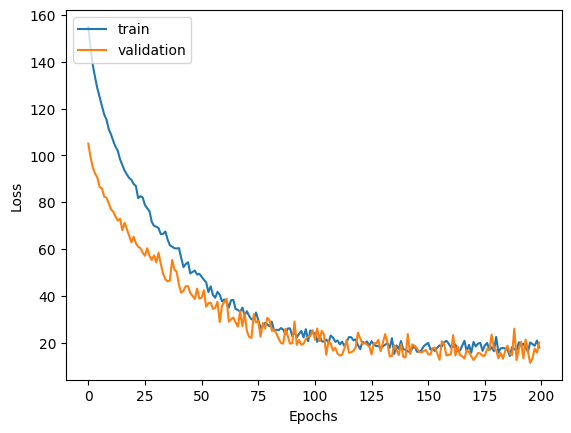

Beginning training ...
Train Epoch: 0 	 Training Loss: 150.151764
Train Epoch: 0 	 Validation Loss: 125.323555
Train Epoch: 20 	 Training Loss: 81.808212
Train Epoch: 20 	 Validation Loss: 73.832932
Train Epoch: 40 	 Training Loss: 54.296726
Train Epoch: 40 	 Validation Loss: 49.742912
Train Epoch: 60 	 Training Loss: 35.739452
Train Epoch: 60 	 Validation Loss: 35.214348
Train Epoch: 80 	 Training Loss: 25.884396
Train Epoch: 80 	 Validation Loss: 21.529860
Train Epoch: 100 	 Training Loss: 25.952652
Train Epoch: 100 	 Validation Loss: 25.832165
Train Epoch: 120 	 Training Loss: 19.366106
Train Epoch: 120 	 Validation Loss: 15.916109
Train Epoch: 140 	 Training Loss: 17.699368
Train Epoch: 140 	 Validation Loss: 20.399593
Train Epoch: 160 	 Training Loss: 18.740906
Train Epoch: 160 	 Validation Loss: 23.787582
Train Epoch: 180 	 Training Loss: 16.749870
Train Epoch: 180 	 Validation Loss: 12.017203


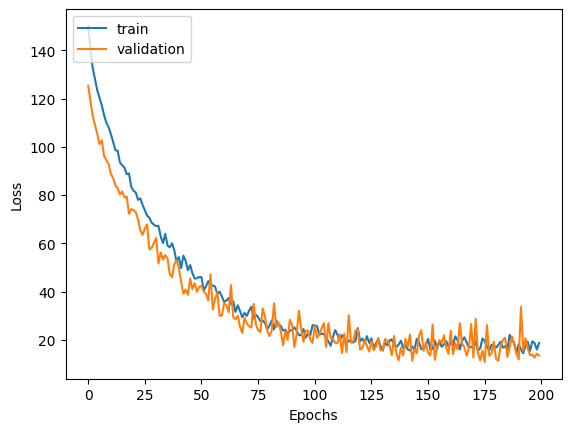

Beginning training ...
Train Epoch: 0 	 Training Loss: 145.374542
Train Epoch: 0 	 Validation Loss: 199.502960
Train Epoch: 20 	 Training Loss: 82.033699
Train Epoch: 20 	 Validation Loss: 116.050552
Train Epoch: 40 	 Training Loss: 57.290710
Train Epoch: 40 	 Validation Loss: 86.151749
Train Epoch: 60 	 Training Loss: 42.266617
Train Epoch: 60 	 Validation Loss: 58.652569
Train Epoch: 80 	 Training Loss: 31.283127
Train Epoch: 80 	 Validation Loss: 44.612328
Train Epoch: 100 	 Training Loss: 25.282976
Train Epoch: 100 	 Validation Loss: 25.027134
Train Epoch: 120 	 Training Loss: 20.859957
Train Epoch: 120 	 Validation Loss: 22.462067
Train Epoch: 140 	 Training Loss: 17.345934
Train Epoch: 140 	 Validation Loss: 26.328508
Train Epoch: 160 	 Training Loss: 17.817162
Train Epoch: 160 	 Validation Loss: 18.202919
Train Epoch: 180 	 Training Loss: 16.748280
Train Epoch: 180 	 Validation Loss: 19.857430


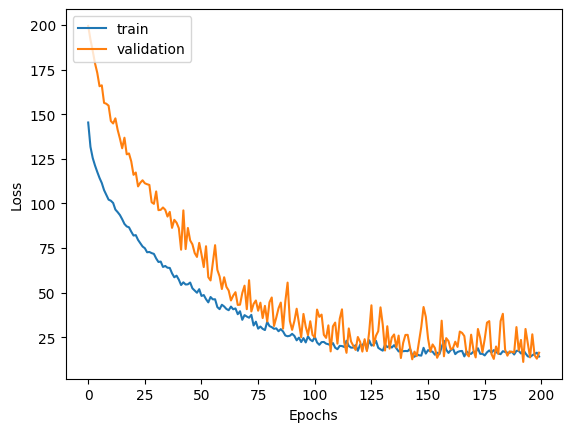

Beginning training ...
Train Epoch: 0 	 Training Loss: 137.538940
Train Epoch: 0 	 Validation Loss: 137.389801
Train Epoch: 20 	 Training Loss: 79.515381
Train Epoch: 20 	 Validation Loss: 88.336426
Train Epoch: 40 	 Training Loss: 55.485218
Train Epoch: 40 	 Validation Loss: 60.674309
Train Epoch: 60 	 Training Loss: 39.741581
Train Epoch: 60 	 Validation Loss: 42.983902
Train Epoch: 80 	 Training Loss: 29.216030
Train Epoch: 80 	 Validation Loss: 33.090603
Train Epoch: 100 	 Training Loss: 24.202305
Train Epoch: 100 	 Validation Loss: 29.223362
Train Epoch: 120 	 Training Loss: 21.272701
Train Epoch: 120 	 Validation Loss: 23.965853
Train Epoch: 140 	 Training Loss: 17.135157
Train Epoch: 140 	 Validation Loss: 20.793133
Train Epoch: 160 	 Training Loss: 17.598370
Train Epoch: 160 	 Validation Loss: 15.659384
Train Epoch: 180 	 Training Loss: 16.916679
Train Epoch: 180 	 Validation Loss: 13.991739


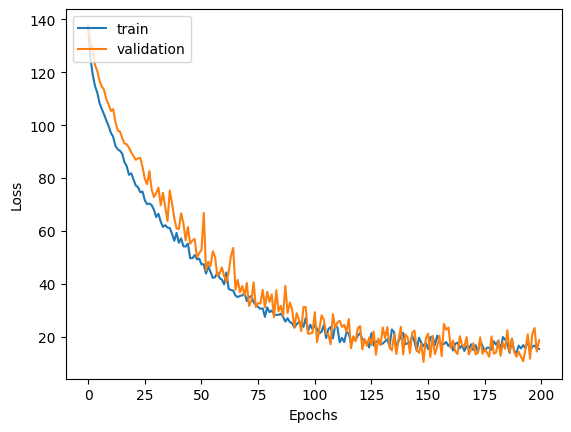

In [253]:

from patsy import dmatrix, build_design_matrices
from sklearn.utils import resample
from collections import defaultdict
from operator import itemgetter


# define data location
data_path = '../data/simple_gam/X.csv'
target_path = '../data/simple_gam/Y.csv'
# read data into pandas dataframe
data = pd.read_csv(data_path,delimiter=';')
target = pd.read_csv(target_path)
data_total = pd.concat([data, target], axis=1)

# define distribution and the formula for the distibutional parameter
distribution  = 'Poisson'
formulas = {'rate': '~1+spline(x1, bs="bs",df=9)+spline(x2, bs="bs",df=9)+d1(x1)+d2(x2)'}

# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 1000,
    'epochs': 200,
    'degrees_of_freedom': {'rate': 6},
    'optimizer' : optim.RMSprop,
    'val_split': 0.1,
    'dropout_rate': 0.1
    }

# define output directory
output_dir = './outputs'
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

# Perform bootstrapping
n_iterations = 10
param = 'rate'
# Initialize a defaultdict with list as the default value type
structured_pred_bootstrapping = defaultdict(list)
partial_effects = defaultdict(list)
feature = defaultdict(list)
can_plot = defaultdict(list)
# Fit a spline model
for _ in range(n_iterations):
    data_total_sample = resample(data_total).reset_index()
    data_sample = data_total_sample.iloc[:,:-1]
    target_sample = data_total_sample.iloc[:,-1]
    # split the data into train and test to use later for predictions
    train_data = data_sample.iloc[:800]
    train_target = pd.DataFrame(target_sample.iloc[:800])
    test_data = data_sample.iloc[800:]
    
    sddr.train(structured_data=train_data,
                target=train_target,
                plot=True)
    
    data_sddr = sddr.dataset[:]["datadict"]
    get_feature = sddr.dataset.get_feature
    xlabels = []
    ylabels = []
    # get the weights of the linear layer of the structured part - do this computation on cpu
    structured_head_params = sddr.net.single_parameter_sddr_list[param].structured_head.weight.detach().cpu()
    # and the structured data after the smoothing
    smoothed_structured = data_sddr[param]["structured"].cpu()
    # get a list of the slice that each spline has in the design matrix
    list_of_spline_slices = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_slices']
    # get a list of the names of spline terms   
    list_of_term_names = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_term_names']
    # get a list of feature names sent as input to each spline
    list_of_spline_input_features = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_input_features']

    # for each spline
    for spline_slice, spline_input_features, term_name in zip(list_of_spline_slices, list_of_spline_input_features, list_of_term_names):
        
        # if only one feature was sent as input to spline
        if len(spline_input_features) == 1:
            # get that feature
            feature[spline_input_features[0]].append(get_feature(spline_input_features[0]))
            # and keep track so that the partial effect of this spline can be plotted later on
            can_plot[spline_input_features[0]].append(True)
            ylabels.append(term_name)
            xlabels.append(spline_input_features[0])
        else:
            feature = defaultdict(list)
            for feature_name in spline_input_features:
                feature[feature_name].append(get_feature(feature_name))
                # the partial effect of this spline cannot be plotted later on - too complicated for now as not 2d
                can_plot[feature_name].append(False)
            
        # once for each structured_pred_bootstrapping
        structured_pred = torch.matmul(smoothed_structured[:,spline_slice], structured_head_params[0, spline_slice])
        structured_pred_bootstrapping[spline_input_features[0]].append(structured_pred.numpy())


In [254]:

for i in xlabels:
    # mean of the dropouted result
    # print(len(structured_pred_bootstrapping[i][0]))
    feature_re_iter = []
    structured_pred_re_iter = []
    
    for j in range(n_iterations):
        fp_re = np.array([[f,p] for f,p in sorted(zip(feature[i][j], structured_pred_bootstrapping[i][j]))])
        feature_re, structured_pred_bootstrapping_re = fp_re[:,0],fp_re[:,1]
        feature_re_iter.append(feature_re)
        structured_pred_re_iter.append(structured_pred_bootstrapping_re)
    
    feature_mean = np.mean(np.array(feature_re_iter),axis=0)
    structured_pred = np.mean(np.array(structured_pred_re_iter),axis=0)
    
    # calculate 95% quantile and 50% quantile
    ci950 = np.quantile(np.array(structured_pred_re_iter), 0.025, axis=0)
    ci951 = np.quantile(np.array(structured_pred_re_iter), 0.975, axis=0)
    ci250 = np.quantile(np.array(structured_pred_re_iter), 0.25, axis=0)
    ci251 = np.quantile(np.array(structured_pred_re_iter), 0.75, axis=0)
                            
    partial_effects[i].append((feature_mean, structured_pred, ci950, ci951, ci250, ci251))
        

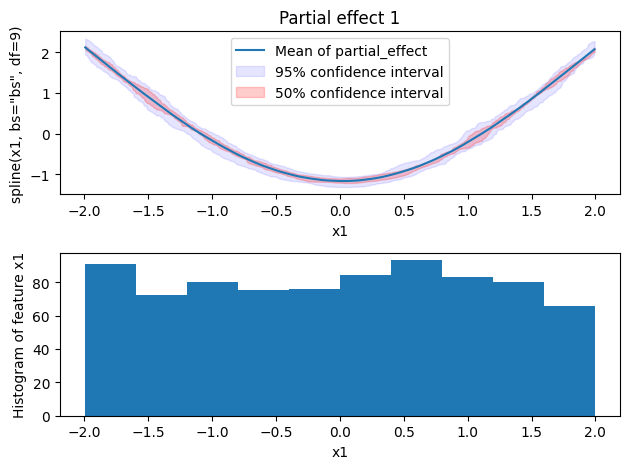

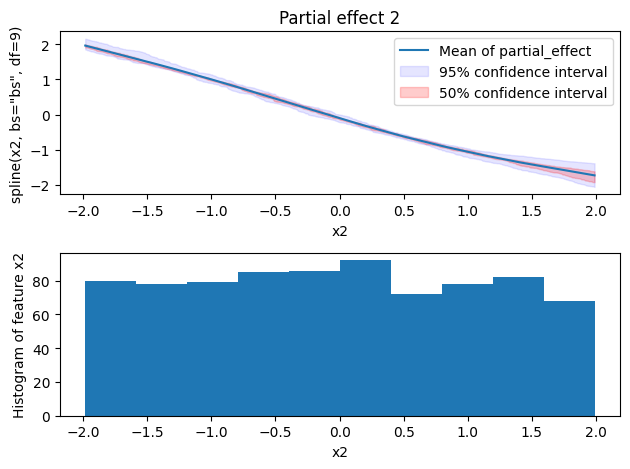

In [255]:
from operator import itemgetter

can_plot_transformed = [sum(can_plot[i])==len(can_plot[i]) for i in can_plot.keys()]
num_plots =  sum(can_plot_transformed)
partial_effects_transformed = dict(map(lambda key: (key, partial_effects[key]), xlabels))


if num_plots == 0:
    print('Nothing to plot. No (non-)linear partial effects specified for this parameter. (Deep partial effects are not plotted.)')
elif num_plots != len(partial_effects_transformed):
    print('Cannot plot ', len(partial_effects_transformed) - num_plots, ' splines because they have more that one input')

for i,v in enumerate(partial_effects_transformed.keys()):
    if can_plot_transformed[i]:
        feature, partial_effect, ci950, ci951, ci250, ci251 = partial_effects_transformed[v][0]
        re = np.array([[x,y,m,n,o] for _,x,y,m,n,o in sorted(zip(feature, partial_effect, ci950, ci951, ci250, ci251))])
        partial_effect, ci950, ci951, ci250, ci251 = re[:,0],re[:,1],re[:,2],re[:,3],re[:,4]
        plt.subplot(2,1,1)
        plt.plot(np.sort(feature), partial_effect,label='Mean of partial_effect')
        plt.fill_between(np.sort(feature), ci950, ci951, color='b', alpha=.1, label='95% confidence interval')
        plt.fill_between(np.sort(feature), ci250, ci251, color='r', alpha=.2,label='50% confidence interval')
        plt.legend()
        plt.title('Partial effect %s' % (i+1))
        plt.ylabel(ylabels[i])
        plt.xlabel(xlabels[i])
        plt.subplot(2,1,2)
        plt.hist(feature,bins=bins)
        plt.ylabel('Histogram of feature {}'.format(xlabels[i]))
        plt.xlabel(xlabels[i])
        plt.tight_layout()
        plt.show()
#             plt.savefig(os.path.join(self.config['output_dir'], 'partial_effects.png'))

#### VI in structured part


In [260]:
import torch.nn.functional as F
# Data process

# define data location
data_path = '../data/simple_gam/X.csv'
target_path = '../data/simple_gam/Y.csv'
# read data into pandas dataframe
data = pd.read_csv(data_path,delimiter=';')
target = pd.read_csv(target_path)
# split the data into train and test to use later for predictions
train_data = data.iloc[:800]
train_target = target.iloc[:800]
test_data = data.iloc[800:]


For the structured part of the model, we introduce **variational distributions** over the weights. Instead of a fixed weight $\mathbf{W}_s$, we assume:

$$\mathbf{W}_s \sim \mathcal{N}(\mu_w, \sigma_w^2)$$

where:
- $\mu_w$ is the mean of the weight distribution
- $\sigma_w^2 = \exp(\log \sigma_w^2)$ is the variance of the weight distribution.

This means that during each forward pass, we **sample weights** from this distribution to capture uncertainty in the model's predictions.

The forward pass in the structured component is:

$$\mathbf{y}_s = \mathbf{X}_s \mathbf{W}_s + \mathbf{b}$$

where $\mathbf{W}_s$ and $\mathbf{b}$ are sampled from the learned variational distributions.


In [259]:
class VariationalLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Initialize variational parameters for mean and log variance
        self.mu = nn.Parameter(torch.randn(in_features, out_features))
        self.log_var = nn.Parameter(torch.randn(in_features, out_features))

    def forward(self, x):
        # Sample weights from the Gaussian distribution: W_s ~ N(mu_w, sigma_w^2)
        std = torch.exp(0.5 * self.log_var)
        epsilon = torch.randn_like(std)  # Sample noise from standard normal
        W_s = self.mu + std * epsilon  # Reparameterization trick

        # Forward pass: structured prediction
        return torch.mm(x, W_s)


**Explanation:**
- `mu`: The mean of the Gaussian distribution.
- `log_var`: Log variance to ensure positivity after exponentiation.
- `std = torch.exp(0.5 * self.log_var)`: The standard deviation.
- `epsilon`: Standard Gaussian noise for reparameterization trick.
- The forward pass samples $\mathbf{W}_s$ from the variational distribution and computes the output using these sampled weights.

### **2. Evidence Lower Bound (ELBO) Loss**

#### Theory:
The ELBO loss combines two terms:
$$\mathcal{L}_{\text{ELBO}} = \mathbb{E}_{q(\mathbf{W}_s)}[\log p(y | \mathbf{X}_s, \mathbf{W}_s)] - \text{KL}(q(\mathbf{W}_s) || p(\mathbf{W}_s))$$
- The **likelihood** term: Encourages the model to fit the data.
- The **KL-divergence**: Penalizes the learned distribution from deviating too much from the prior.



In [ ]:
class ELBO_Loss(nn.Module):
    def __init__(self, kl_weight=0.01):
        super().__init__()
        self.kl_weight = kl_weight

    def forward(self, y_pred, y_true, mu, log_var):
        # Likelihood term: Mean squared error (or another suitable likelihood)
        likelihood_loss = F.mse_loss(y_pred, y_true)

        # KL-divergence: KL between q(W_s) and p(W_s) ~ N(0, I)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # ELBO: Likelihood - KL divergence
        elbo_loss = likelihood_loss + self.kl_weight * kl_div
        return elbo_loss


**Explanation:**
- `likelihood_loss = F.mse_loss(y_pred, y_true)`: The likelihood term uses mean squared error.
- `kl_div`: KL divergence between the variational distribution $q(\mathbf{W}_s)$ and the prior $p(\mathbf{W}_s)$, which is assumed to be $\mathcal{N}(0, I)$.
- `elbo_loss`: The total loss is a combination of the likelihood and the KL-divergence, with a weight $\lambda$ to control the trade-off.

### **3. Monte Carlo Sampling for Uncertainty Quantification**

#### Theory:
To estimate the predictive mean and variance, we use **Monte Carlo (MC) sampling**. For each input, we sample $\mathbf{W}_s$ multiple times from the variational distribution and calculate both the mean prediction and uncertainty.

The mean and variance are given by:
$$\hat{y}_s = \frac{1}{K} \sum_{k=1}^{K} \hat{y}_s^{(k)}, \quad \text{Var}(\hat{y}_s) = \frac{1}{K} \sum_{k=1}^{K} \left( \hat{y}_s^{(k)} - \hat{y}_s \right)^2$$


In [ ]:
def monte_carlo_predict(model, x, num_samples=100):
    preds = []
    for _ in range(num_samples):
        # Sample model predictions using sampled weights
        preds.append(model(x))
    
    preds = torch.stack(preds)
    mean_pred = preds.mean(dim=0)
    var_pred = preds.var(dim=0)
    
    return mean_pred, var_pred

**Explanation:**
- `monte_carlo_predict`: Samples predictions using the model multiple times to account for uncertainty in the weights.
- `mean_pred`: The mean of the sampled predictions.
- `var_pred`: The variance of the predictions, which captures uncertainty.



Using device:  cpu
Beginning training ...
Train Epoch: 0 	 Training Loss: 160.667953
Train Epoch: 0 	 Validation Loss: 120.799782
Train Epoch: 20 	 Training Loss: 95.353340
Train Epoch: 20 	 Validation Loss: 78.067413
Train Epoch: 40 	 Training Loss: 63.313618
Train Epoch: 40 	 Validation Loss: 56.551487
Train Epoch: 60 	 Training Loss: 46.259472
Train Epoch: 60 	 Validation Loss: 37.997475
Train Epoch: 80 	 Training Loss: 30.971432
Train Epoch: 80 	 Validation Loss: 24.522831
Train Epoch: 100 	 Training Loss: 24.120470
Train Epoch: 100 	 Validation Loss: 27.894966
Train Epoch: 120 	 Training Loss: 19.905037
Train Epoch: 120 	 Validation Loss: 24.494318
Train Epoch: 140 	 Training Loss: 19.095303
Train Epoch: 140 	 Validation Loss: 14.449738
Train Epoch: 160 	 Training Loss: 16.982214
Train Epoch: 160 	 Validation Loss: 13.296294
Train Epoch: 180 	 Training Loss: 15.656430
Train Epoch: 180 	 Validation Loss: 16.943623


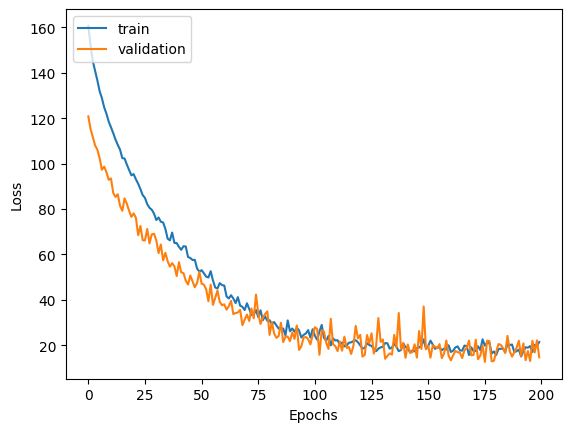

torch.Size([1, 19])
torch.Size([800, 19])
[slice(1, 10, None), slice(10, 19, None)]
['spline(x1, bs="bs", df=9)', 'spline(x2, bs="bs", df=9)']
[['x1'], ['x2']]


In [256]:


sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

sddr.train(structured_data=train_data,
           target=train_target,
           plot=True)

##### how they quantify the uncertainty for a specific parameter of the distribution
param = 'rate'
data = sddr.dataset[:]["datadict"]
# print(data)
get_feature = sddr.dataset.get_feature

# get the weights of the linear layer of the structured part - do this computation on cpu
structured_head_params = sddr.net.single_parameter_sddr_list[param].structured_head.weight.detach().cpu()
# print(structured_head_params)
print(structured_head_params.size())

# and the structured data after the smoothing
smoothed_structured = data[param]["structured"].cpu()
# print(smoothed_structured)
print(smoothed_structured.size())

# get a list of the slice that each spline has in the design matrix
list_of_spline_slices = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_slices']
print(list_of_spline_slices)

# get a list of the names of spline terms
list_of_term_names = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_term_names']
print(list_of_term_names)

 # get a list of feature names sent as input to each spline
list_of_spline_input_features = sddr.prepare_data.dm_info_dict[param]['spline_info']['list_of_spline_input_features']
print(list_of_spline_input_features)




# Assuming the existing SDDR structure for the model
class SddrWithVI(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SddrWithVI, self).__init__()
        # Variational Linear layer for the structured part
        self.variational_layer = VariationalLinear(input_dim, output_dim)

    def forward(self, x):
        # Forward pass through the variational layer
        return self.variational_layer(x)

# Define model, training hyperparameters, and optimizer
input_dim = smoothed_structured.shape[1]  # Use the input dimension from your structured data
output_dim = 1  # Assuming single output (e.g., rate parameter)
model = SddrWithVI(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [257]:

# Variational Inference and Uncertainty Quantification
num_samples = 100  # Number of Monte Carlo samples for uncertainty estimation
num_epochs = 200

partial_effects = []
can_plot = []
xlabels = []
ylabels = []

# Training loop with variational inference
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = []
    for _ in range(num_samples):
        structured_pred = model(smoothed_structured)
        outputs.append(structured_pred)
    
    # Stack outputs from multiple samples and compute mean and variance
    outputs = torch.stack(outputs)
    pred_mean = outputs.mean(dim=0)
    pred_var = outputs.var(dim=0)
    
    # Loss function incorporates both mean and variance (you can adjust this)
    loss = torch.mean((pred_mean - target)**2 + pred_var)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



ValueError: Unable to coerce list of <class 'torch.Tensor'> to Series/DataFrame

In [ ]:

# After training, evaluate and plot uncertainty for each feature
with torch.no_grad():
    for i, (spline_slice, spline_input_features, term_name) in enumerate(zip(list_of_spline_slices, list_of_spline_input_features, list_of_term_names)):
        if len(spline_input_features) == 1:
            feature = get_feature(spline_input_features[0])
            can_plot.append(True)
            ylabels.append(term_name)
            xlabels.append(spline_input_features[0])
        else:
            can_plot.append(False)
        
        outputs = []
        for _ in range(num_samples):
            structured_pred = model(smoothed_structured[:, spline_slice])
            outputs.append(structured_pred)
        
        outputs = torch.stack(outputs)
        pred_mean = outputs.mean(dim=0).numpy()
        pred_var = outputs.var(dim=0).numpy()
        
        # Compute confidence intervals
        ci950 = pred_mean - 1.96 * np.sqrt(pred_var)
        ci951 = pred_mean + 1.96 * np.sqrt(pred_var)
        ci250 = pred_mean - 0.675 * np.sqrt(pred_var)
        ci251 = pred_mean + 0.675 * np.sqrt(pred_var)
        
        partial_effects.append((feature, pred_mean, ci950, ci951, ci250, ci251))

# Plot the results
for i in range(len(partial_effects)):
    if can_plot[i]:
        feature, partial_effect, ci950, ci951, ci250, ci251 = partial_effects[i]
        re = np.array([[x, y, m, n, o] for _, x, y, m, n, o in sorted(zip(feature, partial_effect, ci950, ci951, ci250, ci251))])
        partial_effect, ci950, ci951, ci250, ci251 = re[:, 0], re[:, 1], re[:, 2], re[:, 3], re[:, 4]
        
        plt.subplot(2, 1, 1)
        plt.plot(np.sort(feature), partial_effect, label='Mean of partial effect')
        plt.fill_between(np.sort(feature), ci950, ci951, color='b', alpha=.1, label='95% confidence interval')
        plt.fill_between(np.sort(feature), ci250, ci251, color='r', alpha=.2, label='50% confidence interval')
        plt.legend()
        plt.title(f'Partial effect {i + 1}')
        plt.ylabel(ylabels[i])
        plt.xlabel(xlabels[i])
        
        plt.subplot(2, 1, 2)
        plt.hist(feature, bins=10)
        plt.ylabel(f'Histogram of feature {xlabels[i]}')
        plt.xlabel(xlabels[i])
        plt.tight_layout()
        plt.show()